### Import dependencies and set plotting defaults

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import PyPDF2
import io
import cmocean
from pdfo import pdfo

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

### Fitting the CO$_2$ gas cycle
We follow the methodology of Jenkins et al. (2018). In GIR the gas cycles is modelled by the following set of equations:

$$
\frac{\text{d}R_{i}(t)}{\text{d}t} = a_{i}E(t) - \frac{R_{i}(t)}{\alpha \tau_{i}} ,\\
C(t) = C_0 + \sum_{i=1}^{n}{R_{i}(t)} \quad \text{and} \\
\alpha(t) = g_0 \cdot \text{sinh}\Big(\frac{r_0 + r_uG_{u}(t) + r_TT(t) + r_aG_a(t)}{g_1}\Big) ;\\
\text{where}\quad g_1 = \sum_{i=1}^{n}{a_i\tau_i\big[1 - \big(1 + h/\tau_i\big)\text{e}^{-h/\tau_i}\big]} \quad\text{and} \\
g_0 = \Big[ \text{sinh} \Big( \frac{ \sum_{i=1}^{n}{a_i \tau_i [1 - \text{e}^{-h/ \tau_i}]}}{g_1} \Big) \Big] ^{-1}. 
$$

By default for CO$_2$ we set $n=4$, as is done in Joos et al. (2013). With $\alpha$ set to $1$, these equations represent a carbon cycle in which CO$_2$ is released into four atmospheric pools, each representing a different sink out of the atmosphere. In the FaIR model (Millar et al,2017), which GIR is based upon, these sinks represent (in order of increased uptake timescale): rapid biospheric uptake/ocean mixed-layer invasion; biospheric uptake/ocean thermocline invasion; deep ocean invasion/equilibration; geological re-absorption. The FaIR model introduced a state dependence to the 4-box fixed timescale model through an $\alpha$ parameter, which adjusts the timescales of each sink as the state of the model changes. In both FaIR and GIR, this timescale adjustment depends on the quantity of CO$_2$ removed from the atmosphere, $G_u$, and the surface temperature, $T$ (hence the atmospheric burden coefficient, $r_a=0$ by default). In FaIR, $\alpha$ was determined by a parameterisation of the 100-year integrated impulse response function (iIRF100, the airbourne fraction of CO$_2$ integrated over a 100-year period), and required the root of a non-linear equation to be numerically found at each timestep. We have found that the solution to this equation can be very well represented by the form of $\alpha$ shown above. The $g_1$ and $g_2$ coefficients set this analytical approximation exactly equal to the numerical solution at $\alpha=1$.

We fit these equations to CO$_2$ emission data from the Global Carbon Project (Friedlingstein et al, 2019); concentration data from the CMIP6 concentration database, extended to 2019 with the latest NOAA mole fraction data; and observed global mean temperatures from Berkeley Earth, smoothed with a Butterworth filter to remove internal variability.

The Jenkins et al. fitting procedure is as follows:
- re-express the $\alpha$ equation into the following format:
$$
\alpha(t) = g_0 \cdot \text{sinh}\Big[\frac{\gamma \, ( r_0 + \beta \, \{ r_uG_{u}(t) + r_TT(t) + r_aG_a(t) \} )}{g_1}\Big].
$$
- fit $\gamma$ and $\beta$ by inverting the observed concentrations to CO$_2$ emissions using GIR, and matching the a) cumulative emissions and b) change between the 2000-2009 and 2010-2019 average emissions to the GCP data.

This way of expressing $\alpha$ fixes the ratio $r_u / r_T$, the same assumption as in Jenkins et al (2018). We keep this ratio at the value given in Millar et al (2017), which was based on experiments in Gregory (2009) and Aurora (2013). This is done as $r_U$ and $r_T$ have a similar impact on the evolution of airbourne fraction over the historical period and fitting them independently could result in a spuriously high sensitivity to one feedback and lowered sensitivity to the other with little real difference in the quality of the fit.

#### import concentration datasets ####

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


<AxesSubplot:>

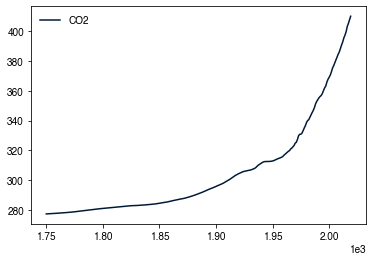

In [2]:
## import concentrations:
CMIP6_conc_ftp = ftplib.FTP('data.iac.ethz.ch','anonymous')
CMIP6_conc_ftp.cwd('CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701')
CMIP6_ftp_list = [x for x in CMIP6_conc_ftp.nlst() if x[-3:]=='csv']
WMGHG_concs = pd.DataFrame(dict(zip(['_'.join(x.split('_')[3:-8]) for x in CMIP6_ftp_list],[pd.read_csv('ftp://data.iac.ethz.ch/CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701/'+x,usecols=[0,1],index_col=0).iloc[:,0] for x in CMIP6_ftp_list])))
WMGHG_concs = WMGHG_concs[[x for x in WMGHG_concs.columns if x[-2:]!='eq']] # remove "equivalent" concentrations

WMGHG_concs['halon1202'] = 0
WMGHG_concs.loc[1765:2014,'halon1202'] = pd.read_csv('http://www.pik-potsdam.de/~mmalte/rcps/data/RCP45_MIDYEAR_CONCENTRATIONS.DAT',skiprows=38,delim_whitespace=True,index_col=0)['HALON1202'].loc[1765:2014].values

NOAA_mole_fractions_2020 = pd.read_csv('https://www.esrl.noaa.gov/gmd/aggi/NOAA_MoleFractions_2020.csv',skiprows=2,index_col=0,skipfooter=5).iloc[1:].replace('nd',np.nan).apply(pd.to_numeric)

scale_factor = (WMGHG_concs.loc[2014,'carbon_dioxide'] / NOAA_mole_fractions_2020.loc[2014:2015,'CO2']).values

CO2_concs = pd.Series(np.append(WMGHG_concs.loc[1750:,'carbon_dioxide'].values.flatten(),NOAA_mole_fractions_2020.loc[2015:,'CO2']*scale_factor),index=np.arange(1750,2020),name='CO2')

CO2_concs.plot(legend=True)

#### import emission dataset ####

<AxesSubplot:xlabel='Year'>

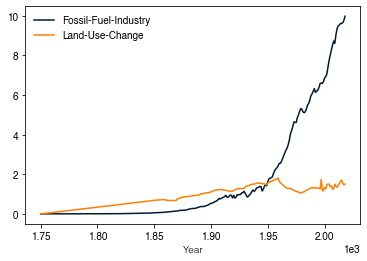

In [3]:
GCP_historical_emissions=pd.read_csv('https://raw.githubusercontent.com/openclimatedata/global-carbon-budget/master/data/historical-budget.csv',index_col=0,usecols=[0,1,2])
# set 1750 value to 0
GCP_historical_emissions.loc[1750,'Fossil-Fuel-Industry'] = 0
# linearly interpolate between 0 and first land-use-change datapoint
GCP_historical_emissions.loc[1750:1849,'Land-Use-Change'] = np.linspace(0,0.99,100) * GCP_historical_emissions.loc[1850,'Land-Use-Change']

GCP_historical_emissions.plot()

#### import temperature dataset ####

<AxesSubplot:xlabel='Year'>

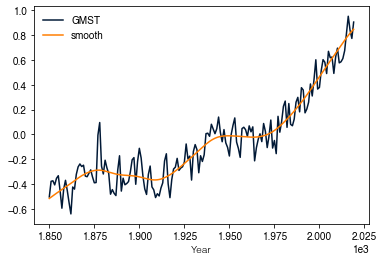

In [4]:
BE_GMST = pd.read_csv('http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_summary.txt',skiprows=48,index_col=0,usecols=[0,1],names=['Year','GMST'],delim_whitespace=True)
b, a = sp.signal.butter(2, 0.05)
BE_GMST['smooth'] = sp.signal.filtfilt(b, a, BE_GMST.values.flatten())
BE_GMST.plot()

#### matching inverse emissions to observed quantities for CO$_2$ ####

In [5]:
fit_concs = pd.concat([pd.DataFrame(CO2_concs)],keys=['observed'],axis=1)
fit_temp = BE_GMST['smooth']-BE_GMST.loc[1850:1900,'smooth'].mean()
## add on 100 years of data that interpolates the 1750-1850 temperature change with a linear fit
fit_temp = np.concatenate((np.zeros(100),fit_temp.values))

In [6]:
## We match the 1850-2018 cumulative emission quantity

r0: [28.8020205]


Text(0.5, 1.0, 'Cumulative emissions (GtC)')

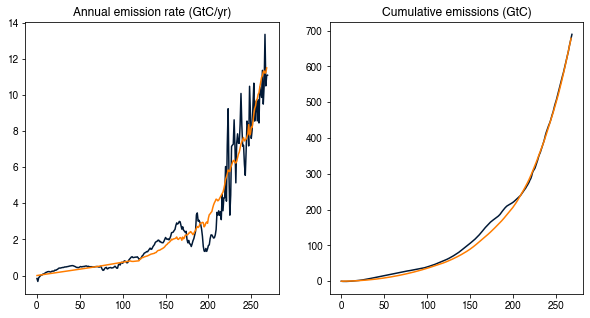

In [7]:
params = get_gas_parameter_defaults(['CO2']).apply(pd.to_numeric)
a = params.loc['a1':'a4',('default','CO2')].values
tau = params.loc['tau1':'tau4',('default','CO2')].values
r = np.array([32.4,0.019,4.165,0])
PI_conc = 278
emis2conc = params.loc['emis2conc',('default','CO2')]

def get_r0(x):
    r_1 = r.copy()
    r_1[0] = x
    emissions = invert_carbon_cycle_prescribed_T(fit_concs.values,fit_temp,a,tau,r_1,PI_conc,emis2conc).rolling(2).mean()
    emissions.loc[0] = emissions.loc[1]/2
    return abs(emissions.loc[:268].sum() - (GCP_historical_emissions.loc[:2018].sum().sum()))

print('r0:',sp.optimize.root(get_r0,x0=30).x)

r_valid = np.array([sp.optimize.root(get_r0,x0=30).x[0],0.019,4.165,0])
validation = invert_carbon_cycle_prescribed_T(fit_concs.values,fit_temp,a,tau,r_valid,PI_conc,emis2conc).rolling(2).mean()
validation.loc[0] = validation.loc[1]/2

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(validation.values)
ax[0].plot(GCP_historical_emissions.sum(axis=1).values)
ax[1].plot(np.cumsum(validation.values))
ax[1].plot(np.cumsum(GCP_historical_emissions.sum(axis=1).loc[:].values))
ax[0].set_title('Annual emission rate (GtC/yr)')
ax[1].set_title('Cumulative emissions (GtC)')

r0: 31.52 rU: 0.01223 rT: 2.681


Text(0.5, 1.0, 'Cumulative emissions (GtC)')

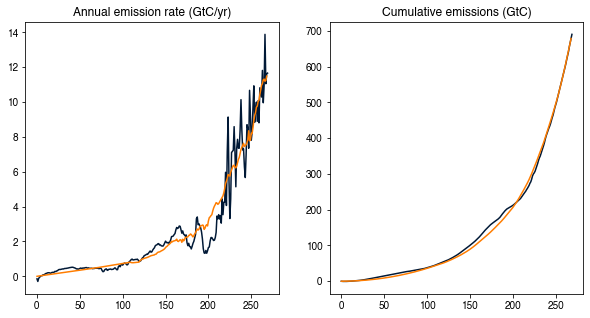

In [8]:
params = get_gas_parameter_defaults(['CO2']).apply(pd.to_numeric)
a = params.loc['a1':'a4',('default','CO2')].values
tau = params.loc['tau1':'tau4',('default','CO2')].values
r = np.array([32.4,0.019,4.165,0])
PI_conc = 278
emis2conc = params.loc['emis2conc',('default','CO2')]

GCP_cumsum = (GCP_historical_emissions.loc[:2018].sum().sum())
GCP_rate = GCP_historical_emissions.loc[2009:2018].mean().sum()

def get_r0_rT(x):
    r_1 = r.copy()
    r_1[0] = x[0]
    r_1[1] = x[1]
    r_1[2] = x[1]/0.019*4.165
    emissions = invert_carbon_cycle_prescribed_T(fit_concs.values,fit_temp,a,tau,r_1,PI_conc,emis2conc).rolling(2).mean()
    emissions.loc[0] = emissions.loc[1]/2
    cumulative_diff = emissions.loc[:268].sum() - (GCP_historical_emissions.loc[:2018].sum().sum())
    rate_diff = emissions.loc[259:268].mean() - GCP_historical_emissions.sum(axis=1).loc[2009:2018].mean()
    return (rate_diff / GCP_rate)**2 + (cumulative_diff / GCP_cumsum)**2 # scale by approximate present day values
#     return np.sum((emissions.loc[100:268].values-GCP_historical_emissions.sum(axis=1).loc[1850:2018].values)**2)

pdfo_results = pdfo(get_r0_rT,x0=[30,0.019],method='bobyqa')
results = pdfo_results.x

print('r0:',round(results[0],2),'rU:',round(results[1],5),'rT:',round(results[1]/0.019*4.165,3))

r_valid = np.array([results[0],results[1],results[1]/0.019*4.165,0])
validation = invert_carbon_cycle_prescribed_T(fit_concs.values,fit_temp,a,tau,r_valid,PI_conc,emis2conc).rolling(2).mean()
validation.loc[0] = validation.loc[1]/2

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(validation.values)
ax[0].plot(GCP_historical_emissions.sum(axis=1).values)
ax[1].plot(np.cumsum(validation.values))
ax[1].plot(np.cumsum(GCP_historical_emissions.sum(axis=1).loc[:].values))
ax[0].set_title('Annual emission rate (GtC/yr)')
ax[1].set_title('Cumulative emissions (GtC)')

## now fitting CH4 and N2O gas cycles ##

For CH$_4$ and N$_2$O we set $n=1$ in the gas cycles equations; modelling these gas cyles as having a single sink from the atmosphere. In reality, both have multiple sinks (eg. soil uptake, stratospheric chemistry, tropospheric Cl for CH$_4$), but we assume that we can capture the majority of the observed response with a single sink as in both cases there is a sink that dominates the gas lifetime (OH chemistry). We follow Holmes et al (2015) and Prather et al (2015) to determine which lifetime feedbacks to include. We include feedbacks on their own atmospheric burden for both CH$_4$ and N$_2$O, and a feedback on GMST for CH$_4$. All other $r$ feedback parameters are set to zero. Here we parameterise the CH$_4$ tropospheric air temperature and water vapour sensitivities in Holmes et al with $r_T$, and the atmospheric burden self-feedback for CH$_4$ and N$_2$O with $r_C$.

In [9]:
## This function computes the CH4 lifetime from Holmes including water vapour, air temperature and CH4 concentration sensitivities

def calculate_Holmes_CH4_life(T,C,sT=-3,sMR=-0.32,sC=0.31,a1=0.94,a2=1.5):
    
    atmos_temp = 251.9 + a1 * (T - T.loc[2010])
    
    sat_vap_pressure =  6.112*(np.exp(6816*(1/273.15 - 1/atmos_temp) + 5.1309 * np.log(273.15/atmos_temp)))
    
    MR,T = 2.45 * (1 + a2 * (sat_vap_pressure - sat_vap_pressure.loc[2010]) / sat_vap_pressure.loc[2010]) , atmos_temp
    
    feedback = (T/T.loc[2010]) ** sT * (MR / MR.loc[2010]) ** sMR * (C / C.loc[2010]) ** sC
    
    return ( (11.2*feedback)**-1 + 1/150 + 1/120 + 1/200 ) ** (-1)

#### import CH4 and N2O concentrations

<AxesSubplot:>

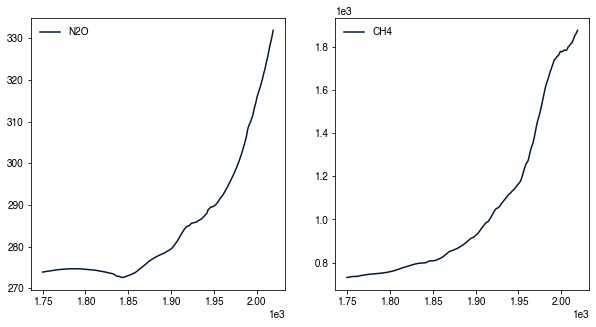

In [10]:
scale_factor = (WMGHG_concs.loc[2014,'methane'] / NOAA_mole_fractions_2020.loc[2014:2015,'CH4']).values
CH4_concs = pd.Series(np.append(WMGHG_concs.loc[1750:,'methane'].values.flatten(),NOAA_mole_fractions_2020.loc[2015:,'CH4']*scale_factor),index=np.arange(1750,2020),name='CH4')

scale_factor = (WMGHG_concs.loc[2014,'nitrous_oxide'] / NOAA_mole_fractions_2020.loc[2014:2015,'N2O']).values
N2O_concs = pd.Series(np.append(WMGHG_concs.loc[1750:,'nitrous_oxide'].values.flatten(),NOAA_mole_fractions_2020.loc[2015:,'N2O']*scale_factor),index=np.arange(1750,2020),name='N2O')

fig,ax = plt.subplots(1,2,figsize=(10,5))
N2O_concs.plot(ax=ax[0],legend=True)
CH4_concs.plot(ax=ax[1],legend=True)

#### fit CH$_4$ $r_T$, $r_A$ feedbacks to Holmes (2013) sensitivities ####

We linearise the GIR CH$_4$ feedback about the present-day (2010), and fit these to the Holmes sensitivities. Since the feedback terms are small, this approximation is reasonable.

In [11]:
T_2010_perturb = pd.DataFrame([BE_GMST.loc[2005:2015,'GMST'].mean(),BE_GMST.loc[2005:2015,'GMST'].mean()+0.01],index=[2010,'delta'])
T_2010_const = pd.DataFrame([BE_GMST.loc[2005:2015,'GMST'].mean(),BE_GMST.loc[2005:2015,'GMST'].mean()],index=[2010,'delta'])

C_2010_perturb = pd.DataFrame([CH4_concs.loc[2010],CH4_concs.loc[2010]+0.01],index=[2010,'delta'])
C_2010_const = pd.DataFrame([CH4_concs.loc[2010],CH4_concs.loc[2010]],index=[2010,'delta'])

In [12]:
# N = 5000

# rT_distr = np.zeros(N)
# rC_distr = np.zeros(N)
    
# for i in np.arange(N):

#     sT= np.random.normal(-3,0.8)
#     sMR= np.random.normal(-0.32,0.03)
#     sC= np.random.normal(0.31,0.04)
#     a1= np.random.normal(0.94,0.1)
#     a2= np.random.normal(1.5,0.1)
    
#     linearise_T = calculate_Holmes_CH4_life(T_2010_perturb,C_2010_const,sT=sT,sMR=sMR,sC=sC,a1=a1,a2=a2)[0]
#     linearise_C = calculate_Holmes_CH4_life(T_2010_const,C_2010_perturb,sT=sT,sMR=sMR,sC=sC,a1=a1,a2=a2)[0]
    
#     tau_2010 = linearise_T.loc[2010]    
#     g1 = tau_2010 * ( 1. - ( 1. + 100/tau_2010 ) * np.exp(-100/tau_2010) )
#     g0 = ( np.sinh( tau_2010 * ( 1. - np.exp(-100/tau_2010) )  / g1 ) )**(-1.)
#     linearised_coeff = ( ( g0/g1 ) * np.cosh((np.arcsinh(1/g0))) )
    
#     rT_distr[i] = ( linearise_T.loc['delta'] - linearise_T.loc[2010] ) / (0.01 * linearise_T.loc[2010] * linearised_coeff)
#     rC_distr[i] = ( linearise_C.loc['delta'] - linearise_C.loc[2010] ) * 0.3517 / (0.01 * linearise_C.loc[2010] * linearised_coeff)

In [13]:
# rT_norm_params = sp.stats.norm.fit(rT_distr)
# rC_norm_params = sp.stats.norm.fit(rC_distr)

# xrange_rT = np.linspace(rT_distr.min(),rT_distr.max())
# xrange_rC = np.linspace(rC_distr.min(),rC_distr.max())
    
# fig,ax = plt.subplots(1,2,figsize=(15,6))
# ax[0].hist(rT_distr,bins=50,density=True)
# ax[0].plot(xrange_rT,sp.stats.norm.pdf(xrange_rT,*rT_norm_params),'lightblue')
# ax[0].set_title('rT distribution (MC sample) = N'+str([round(x,3) for x in rT_norm_params]))
# ax[1].hist(rC_distr,bins=50,density=True)
# ax[1].plot(xrange_rC,sp.stats.norm.pdf(xrange_rC,*rC_norm_params),'lightblue')
# ax[1].set_title('rC distribution (MC sample) = N'+str([round(x,6) for x in rC_norm_params]))

#### fit N$_2$O $r_A$ feedbacks to Prather (2015) sensitivities [NO LONGER IMPLEMENTED] ####

We linearise the GIR N$_2$O feedback about the present-day (2010), and fit these to the Prather sensitivity. Since the feedback term is small, this approximation is reasonable.

In [14]:
# N = 5000

# rA_distr = np.zeros(N)

# for i in np.arange(N):

#     tau_sample = np.random.normal(116,9)

#     g1 = tau_sample * ( 1. - ( 1. + 100/tau_sample ) * np.exp(-100/tau_sample) )
#     g0 = ( np.sinh( tau_sample * ( 1. - np.exp(-100/tau_sample) )  / g1 ) )**(-1.)
    
#     sC = np.random.normal(-0.065,0.010)

#     rA_distr[i] = (sC/N2O_concs.loc[2005:2010].mean()) / ( ( g0/g1 ) * np.cosh((np.arcsinh(1/g0))) ) * (1/((5.148*10**18/1e18*28)/28.97))

In [15]:
# rA_norm_params = sp.stats.norm.fit(rA_distr)

# xrange_rA = np.linspace(rA_distr.min(),rA_distr.max())
    
# fig,ax = plt.subplots(1,figsize=(7.5,6))
# ax.hist(rA_distr,bins=50,density=True)
# ax.plot(xrange_rA,sp.stats.norm.pdf(xrange_rA,*rA_norm_params),'lightblue')
# ax.set_title('rA distribution (MC sample) = N'+str([round(x,5) for x in rA_norm_params]))

#### fitting the CH$_4$ and N$_2$O lifetimes ####

Now we fit the $\tau$ parameter for both gases to match the Holmes/Prather present-day (2010) values of 9.15 / 116 respectively.

In [16]:
def GIR_CH4_lifetime(tau,rT,rC,T,C):
    g1 = tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) )
    g0 = ( np.sinh( tau * ( 1. - np.exp(-100/tau) )  / g1 ) )**(-1.)
    r0 = g1*np.arcsinh(1/g0)
    
    return tau * g0*np.sinh((r0+rC*C+rT*T)/g1)

CH4_tau = sp.optimize.newton(lambda x:GIR_CH4_lifetime(x,-0.286,0.000343,(BE_GMST.loc[2010,'smooth']-BE_GMST.loc[1850:1900,'smooth'].mean()),(CH4_concs.loc[2010]-720)/0.351714)-9.15,7)
g1 = CH4_tau * ( 1. - ( 1. + 100/CH4_tau ) * np.exp(-100/CH4_tau) )
g0 = ( np.sinh( CH4_tau * ( 1. - np.exp(-100/CH4_tau) )  / g1 ) )**(-1.)
r0 = g1*np.arcsinh(1/g0)
print('CH4 tau1=',CH4_tau,'CH4 r0=',r0)

CH4 tau1= 8.10662750529147 CH4 r0= 8.106591896000378


In [17]:
def GIR_N2O_lifetime(tau,rC,C):
    g1 = tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) )
    g0 = ( np.sinh( tau * ( 1. - np.exp(-100/tau) )  / g1 ) )**(-1.)
    r0 = g1*np.arcsinh(1/g0)
    
    return tau * g0*np.sinh((r0+rC*C)/g1)

N2O_tau = sp.optimize.newton(lambda x:GIR_N2O_lifetime(x,0,(N2O_concs.loc[2010]-273)/0.200980)-116,67)
g1 = N2O_tau * ( 1. - ( 1. + 100/N2O_tau ) * np.exp(-100/N2O_tau) )
g0 = ( np.sinh( N2O_tau * ( 1. - np.exp(-100/N2O_tau) )  / g1 ) )**(-1.)
r0 = g1*np.arcsinh(1/g0)
print('N2O tau1=',N2O_tau,'N2O r0=',r0)

N2O tau1= 115.99999999999999 N2O r0= 67.01465236238496


## other WMGHG lifetimes & radiative efficiencies

By default in GIR all other well-mixed greenhouse gases have:
- a single gas pool (like CH$_4$ and N$_2$O)
- no sensitivities ($r_u = r_T = r_a = 0$)

We take default lifetimes, radiative efficiencies and oxone depletion potentials for all other species from the 2018 WMO Ozone Assessment, appendix A.

In [18]:
WMGHG_data = pd.DataFrame(index = WMGHG_concs.columns,columns = ['MW','tau','RE','ODP'])

In [19]:
WMGHG_data.loc["c2f6"]=[138.01,10000, 0.25,0]
WMGHG_data.loc["c3f8"]=[188.02,2600, 0.28,0]
WMGHG_data.loc["c4f10"]=[238.027,2600, 0.36,0]
WMGHG_data.loc["c5f12"]=[288.034,4100, 0.41,0]
WMGHG_data.loc["c6f14"]=[338.042,3100, 0.44,0]
WMGHG_data.loc["c7f16"]=[388.049,3000, 0.5,0]
WMGHG_data.loc["c8f18"]=[438.06,3000, 0.55,0]
WMGHG_data.loc["c_c4f8"]=[200.03,3200, 0.32,0]

WMGHG_data.loc["carbon_tetrachloride"]=[153.82,32, 0.174,0.89]
WMGHG_data.loc["cf4"]=[88.0043,50000, 0.09,0]

WMGHG_data.loc["cfc113"]=[187.376,93, 0.3,0.81]
WMGHG_data.loc["cfc114"]=[170.92,189, 0.31,0.5]
WMGHG_data.loc["cfc115"]=[154.466,540, 0.2,0.26]
WMGHG_data.loc["cfc11"]=[137.37,52, 0.26,1]
WMGHG_data.loc["cfc12"]=[120.91,102, 0.32,0.77]

WMGHG_data.loc["ch2cl2"]=[84.93,0.4928266345416712, 0.028,0]
WMGHG_data.loc["ch3ccl3"]=[133.4,5, 0.07,0.15]
WMGHG_data.loc["chcl3"]=[119.37,0.5010404117840324, 0.07,0]

WMGHG_data.loc["halon1202"]=[209.82,2.5, 0.27,1.7]
WMGHG_data.loc["halon1211"]=[165.36,16, 0.29,7.3]
WMGHG_data.loc["halon1301"]=[148.91,72, 0.3,17.1]
WMGHG_data.loc["halon2402"]=[259.823,28, 0.31,15.7]

WMGHG_data.loc["hcfc141b"]=[116.94,9.4, 0.16,0.086]
WMGHG_data.loc["hcfc142b"]=[100.49,18, 0.19,0.04]
WMGHG_data.loc["hcfc22"]=[86.47,11.9, 0.21,0.029]

WMGHG_data.loc["hfc125"]=[120.02,30, 0.23,0]
WMGHG_data.loc["hfc134a"]=[102.03,14, 0.16,0]
WMGHG_data.loc["hfc143a"]=[84.04,51, 0.16,0]
WMGHG_data.loc["hfc152a"]=[66.05,1.6, 0.1,0]
WMGHG_data.loc["hfc227ea"]=[170.03,36, 0.26,0]
WMGHG_data.loc["hfc236fa"]=[152.039,213, 0.24,0]
WMGHG_data.loc["hfc23"]=[70.01,228, 0.18,0]
WMGHG_data.loc["hfc245fa"]=[134.05,7.9, 0.24,0]
WMGHG_data.loc["hfc32"]=[52.02,5.4, 0.11,0]
WMGHG_data.loc["hfc365mfc"]=[148.074,8.9, 0.22,0]
WMGHG_data.loc["hfc4310mee"]=[252.055,17, 0.359,0]

WMGHG_data.loc["methyl_bromide"]=[94.94,0.8, 0.004,0.57]
WMGHG_data.loc["methyl_chloride"]=[50.49,0.9, 0.004,0.015]
WMGHG_data.loc["nf3"]=[71,569, 0.2,0]
WMGHG_data.loc["sf6"]=[146.06,3200, 0.57,0]
WMGHG_data.loc["so2f2"]=[102.06,36, 0.2,0]

## CO$_2$, CH$_4$, N$_2$O radiative forcing parameters

Here we tune the forcing parameters to match the results of Etminan (2016) as closely as possible. We exclude the interactions between species, noting that these are only relevant for extreme high emission scenarios (RCP8.5), which have been shown to be exceptionally unlikely. Other feedbacks and uncertainties not included in SCMs are likely more relevant to the accuracy of simple models for this "worst-case" scenario.

In [20]:
os.system('wget "https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1002%2F2016GL071930&file=grl55302-sup-0001-Supplementary.pdf" -O ./tmp/olbl.pdf')

0

In [21]:
pdffile = PyPDF2.PdfFileReader('./tmp/olbl.pdf')
OLBLtable = pdffile.getPage(2).extractText().replace('\n \n',',').replace('\n','').split(',')[42:-1]
OLBLtable2 = pdffile.getPage(3).extractText().replace('\n \n',',').replace('\n','').split(',')[36:-1]
OLBL_df = pd.concat([pd.DataFrame([OLBLtable[i*15:(i+1)*15] for i in np.arange(38)],columns = ['index','CO2_conc','CH4_conc','N2O_conc','sw','LW_inst_cl','LW_inst','LW_adj','Net','change_rel_to_old_fits','CO2_rf','N2O_rf','CH4_rf','rf_SUM','err_in_new_fits']).set_index('index').iloc[:-1],pd.DataFrame([OLBLtable2[i*15:(i+1)*15] for i in np.arange(11)],columns = ['index','CO2_conc','CH4_conc','N2O_conc','sw','LW_inst_cl','LW_inst','LW_adj','Net','change_rel_to_old_fits','CO2_rf','N2O_rf','CH4_rf','rf_SUM','err_in_new_fits']).set_index('index').iloc[:-1]]).apply(pd.to_numeric)
OLBL_df.loc[1] = [389,1800,323,0,0,0,0,0,np.nan,0,0,0,0,np.nan]

In [22]:
## Tune CO2 to f1 & f3 as in Shi (1992)
CO2_rf = OLBL_df.loc[(OLBL_df['CH4_conc']==1800)&(OLBL_df['N2O_conc']==323),'Net'].values.flatten()
CO2_ppm = OLBL_df.loc[(OLBL_df['CH4_conc']==1800)&(OLBL_df['N2O_conc']==323),'CO2_conc'].values.flatten()
_lr = OLSE_NORM(np.array([np.sqrt(CO2_ppm)-np.sqrt(280),np.log(CO2_ppm/280)]).T,CO2_rf[:,np.newaxis])

print('f1=',_lr['coefs'].flatten()[1],'f3=',_lr['coefs'].flatten()[0])

f1= 4.56509091856077 f3= 0.08608124523764005


In [23]:
print('CO2 f1 =',4.57,'f3 =',0.086)
print(r'CO2 F_2x =',0.086*(np.sqrt(560)-np.sqrt(280))+4.57*(np.log(2)))
print()

for conc in OLBL_df.CO2_conc.unique():
    value = 0.086*(np.sqrt(conc)-np.sqrt(389))+4.57*(np.log(conc/389))
    print(conc,'ppm :','max % err=',((value-OLBL_df.loc[(OLBL_df['CO2_conc']==conc),'CO2_rf'])/value).abs().max()*100,'%',' max abs err=',(value-OLBL_df.loc[(OLBL_df['CO2_conc']==conc),'CO2_rf'])[(value-OLBL_df.loc[(OLBL_df['CO2_conc']==conc),'CO2_rf']).abs().idxmax()])

CO2 f1 = 4.57 f3 = 0.086
CO2 F_2x = 3.763758814906608

389.0 ppm : max % err= nan %  max abs err= 0.0
180.0 ppm : max % err= 3.343434538687831 %  max abs err= 0.13588115321667527
700.0 ppm : max % err= 1.6556328414642412 %  max abs err= 0.05404052692243022
2000.0 ppm : max % err= 1.2709002475272397 %  max abs err= 0.122418429665478


In [24]:
print('CH4 f3 =',0.62/(np.sqrt(1834)-np.sqrt(722)))
print()

for conc in OLBL_df.CH4_conc.unique():
    value = 0.0389*(np.sqrt(conc)-np.sqrt(1800))
    print(conc,'ppb :','max % err=',((value-OLBL_df.loc[(OLBL_df['CH4_conc']==conc),'CH4_rf'])/value).abs().max()*100,'%',' max abs err=',(value-OLBL_df.loc[(OLBL_df['CH4_conc']==conc),'CH4_rf'])[(value-OLBL_df.loc[(OLBL_df['CH4_conc']==conc),'CH4_rf']).abs().idxmax()])

CH4 f3 = 0.038858881308818566

1800.0 ppb : max % err= nan %  max abs err= 0.0
750.0 ppb : max % err= 2.575236123204409 %  max abs err= -0.015066852941853837
3500.0 ppb : max % err= 7.829543593961263 %  max abs err= 0.05096780833634862
340.0 ppb : max % err= 2.4763158695310215 %  max abs err= -0.02310666851201526


In [25]:
print('N2O f3 =',0.18/(np.sqrt(323)-np.sqrt(270)))
print()

for conc in OLBL_df.N2O_conc.unique():
    value = 0.117*(np.sqrt(conc)-np.sqrt(323))
    print(conc,'ppb :','max % err=',((value-OLBL_df.loc[(OLBL_df['N2O_conc']==conc),'N2O_rf'])/value).abs().max()*100,'%',' max abs err=',(value-OLBL_df.loc[(OLBL_df['N2O_conc']==conc),'N2O_rf'])[(value-OLBL_df.loc[(OLBL_df['N2O_conc']==conc),'N2O_rf']).abs().idxmax()])

N2O f3 = 0.11684335748184813

200.0 ppb : max % err= 17.432392048108674 %  max abs err= -0.07811762043001591
525.0 ppb : max % err= 16.96353545490603 %  max abs err= 0.09805929314262907
323.0 ppb : max % err= nan %  max abs err= 0.0


In [26]:
OLBL_df['GIR_SUM'] = 0.086*(np.sqrt(OLBL_df.CO2_conc)-np.sqrt(389))+4.57*(np.log(OLBL_df.CO2_conc/389)) + 0.0389*(np.sqrt(OLBL_df.CH4_conc)-np.sqrt(1800)) + 0.117*(np.sqrt(OLBL_df.N2O_conc)-np.sqrt(323))

Text(0.5, 0.98, 'Absolute Error vs. Etminan')

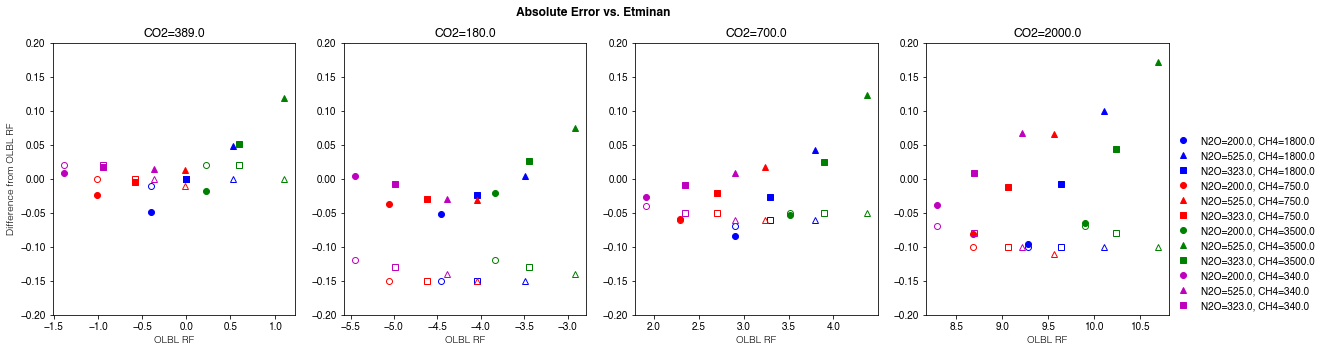

In [27]:
by_CH4 = dict(zip(OLBL_df.CH4_conc.unique(),['b','r','g','m']))
by_N2O = dict(zip(OLBL_df.N2O_conc.unique(),['o','^','s']))

fig,ax =plt.subplots(1,4,figsize=(20,5))
for i,conc in enumerate(OLBL_df.CO2_conc.unique()):
    for CH4_conc,color in by_CH4.items():
        for N2O_conc,marker in by_N2O.items():
            
            select_data = OLBL_df.loc[(OLBL_df['CH4_conc']==CH4_conc)&(OLBL_df['N2O_conc']==N2O_conc)&(OLBL_df['CO2_conc']==conc)]
            
            ax[i].plot(select_data.Net,select_data.GIR_SUM-select_data.Net,marker+color,label='N2O='+str(N2O_conc)+', CH4='+str(CH4_conc))
            
            ax[i].plot(select_data.Net,select_data.rf_SUM-select_data.Net,marker+color,mfc='none')
            
    ax[i].set_title('CO2='+str(conc))
    ax[i].set_ylim(-0.2,0.2)
    ax[i].set_xlabel('OLBL RF')
ax[0].set_ylabel('Difference from OLBL RF')
ax[-1].legend(loc=(1,0))

fig.suptitle('Absolute Error vs. Etminan',fontweight='bold')

Text(0.5, 0.98, 'Relative Error vs. Etminan')

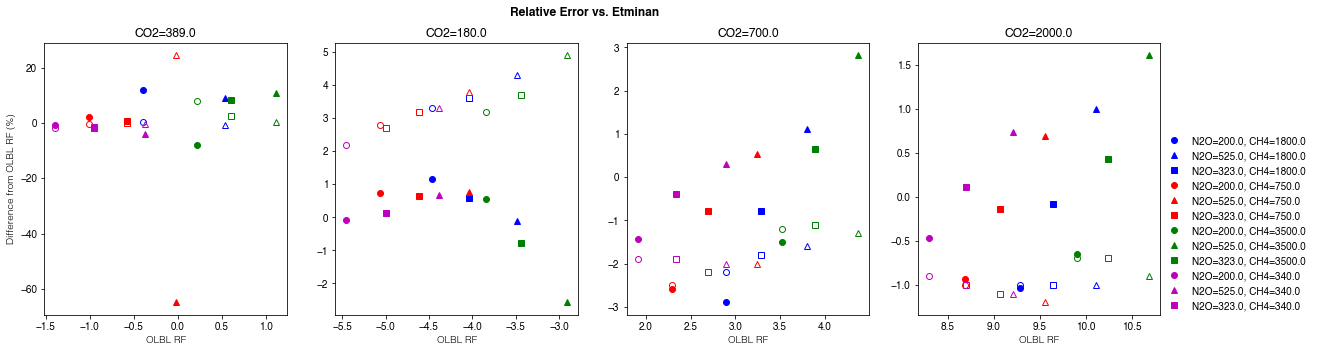

In [28]:
by_CH4 = dict(zip(OLBL_df.CH4_conc.unique(),['b','r','g','m']))
by_N2O = dict(zip(OLBL_df.N2O_conc.unique(),['o','^','s']))

fig,ax =plt.subplots(1,4,figsize=(20,5))
for i,conc in enumerate(OLBL_df.CO2_conc.unique()):
    for CH4_conc,color in by_CH4.items():
        for N2O_conc,marker in by_N2O.items():
            
            select_data = OLBL_df.loc[(OLBL_df['CH4_conc']==CH4_conc)&(OLBL_df['N2O_conc']==N2O_conc)&(OLBL_df['CO2_conc']==conc)]
            
            ax[i].plot(select_data.Net,100*(select_data.GIR_SUM/select_data.Net-1),marker+color,label='N2O='+str(N2O_conc)+', CH4='+str(CH4_conc))
            
            ax[i].plot(select_data.Net,select_data.err_in_new_fits,marker+color,mfc='none')
            
    ax[i].set_title('CO2='+str(conc))
#     ax[i].set_ylim(-0.2,0.2)
    ax[i].set_xlabel('OLBL RF')
ax[0].set_ylabel('Difference from OLBL RF (%)')
ax[-1].legend(loc=(1,0))

fig.suptitle('Relative Error vs. Etminan',fontweight='bold')

## Aerosol radiative parameters

We aim for the following 2011 RFs, based on AR5 (Myhre 2013) and Skeie (2011). Numbers in [] represent a 90% CI. Or maybe we just fit based on Stevens (2015) and AR6?

- SO2 = -0.5 [-0.2 , -0.8]
- BC = 0.4 [0.05 , 0.8]
- OC = -0.13 [-0.2 , -0.05]
- NMVOC = -0.09 [-0.3 , 0.2]
- NOx = -0.044 [-0.12 , -0.012]
- NH3 = -0.066 [-0.18 , -0.018]
- Aci = -0.45 [0 , -1.2]

Aerosol emissions are converted directly into concentrations (ie. tau=1), 

In [29]:
# import emissions from CEDS:
aerosol_species = ['bc','so2','nmvoc','co','oc','nh3','nox']
CEDS_aerosols = pd.concat([pd.read_csv('https://raw.githubusercontent.com/openclimatedata/ceds/master/data/'+x+'.csv').groupby('Year')['Value'].sum() for x in aerosol_species],axis=1,keys=aerosol_species)/1000

### Parameterised aerosols by SO2 (Stevens 2015)

#### aci to the SO2 f1 term

In [30]:
## as in Stevens (2015), take PI emissions to be 60 MtSO2
print('SOx f1 =',-0.9/np.log((CEDS_aerosols.loc[2011,'so2']-6+60)/60))

SOx f1 = -0.8666912171461107


#### ari to the SO2 f2 term

In [31]:
print('SOx f2 =',-0.3/(CEDS_aerosols.loc[2011,'so2']-6))

SOx f2 = -0.0027400493926851063


#### FULL aerosol params following Smith (2018)

In [32]:
#direct ari of species:
print('ari')
print('SOx f2 =',-0.34/(CEDS_aerosols.loc[2011,'so2']))
print('BC f2 =',0.13/(CEDS_aerosols.loc[2011,'bc']))
print('NMVOC f2 =',-0.08/(CEDS_aerosols.loc[2011,'nmvoc']))
print('CO f2 =',0)
print('OC f2 =',-0.05/(CEDS_aerosols.loc[2011,'oc']))
print('NH3 f2 =',-0.066/(CEDS_aerosols.loc[2011,'nh3']))
print('NOx f2 =',-0.044/(CEDS_aerosols.loc[2011,'nox']))
print('aci')
print('SOx f1 =',-0.45/np.log((CEDS_aerosols.loc[2011,'so2']+60)/60))

ari
SOx f2 = -0.002944052335434953
BC f2 = 0.0164749131470319
NMVOC f2 = -0.0004919384433015941
CO f2 = 0
OC f2 = -0.0026185243768950222
NH3 f2 = -0.0011183897607255147
NOx f2 = -0.00030096252150409777
aci
SOx f1 = -0.41929860202869823


### Aerosol parameters following Smith (2020)

Here we base aerosol forcing relations on Smith (2020). ERFari is modelled as a linear combination of SO$_2$, BC and OC emissions. Two forms are trialled for ERFaci: one a linear combination of SO$_2$, BC and OC emissions, the other a combination of a logarithmic SO$_2$ dependence and a linear BC / OC dependence. We reduce the potential number of parameters to avoid overfitting. That is:

$$
ERF_{ari} = \alpha_{SO_2} \cdot E_{SO_2} + \alpha_{BC} \cdot E_{BC} + \alpha_{OC} \cdot E_{OC} \,; \text{and}\\\\
ERF_{aci} = \alpha_{SO_2} \cdot E_{SO_2} + \alpha_{BC} \cdot E_{BC} + \alpha_{OC} \cdot E_{OC} \,; \text{or}\\
ERF_{aci} = \beta \cdot ln\left(1 + \frac{E_{SO_2}}{s}\right) + \alpha \cdot ( E_{OC} + E_{BC} )
$$

In the final ERFaci form, $s$ is treated as a shape parameter, and measures the extent to which aerosol-cloud interaction is linear or logarithmic with SO$_2$ emissions. 

#### Sampling distributions

For ERFari, $\alpha$ samples are taken from a multivariate normal distribution inferred from CMIP6 parameter ranges. The same is done for the linear ERFaci form. For the logarithmic ERFaci form, samples are taken independently from normal distributions inferred from CMIP6 parameter ranges of $\alpha$, $ln(\beta)$, and $ln(\beta/s)$.

In [33]:
## ERFaci & ERFari

### import emissions / forcing:
from zipfile import ZipFile

CMIP6_aer_forc_zip = ZipFile('/home/leachl/Documents/Simple_models/FaIR_v2-0/GIR/tmp/aer_forc_CMIP6.zip')
CMIP6_aer_forc_fnames = [x.filename for x in CMIP6_aer_forc_zip.infolist()]
CMIP6_aer_forc = pd.concat([pd.read_csv(CMIP6_aer_forc_zip.open(x),index_col=0) for x in CMIP6_aer_forc_fnames],axis=1,keys=[x.split('.')[0] for x in CMIP6_aer_forc_fnames])

# CMIP6_aer_emms_zip = ZipFile('/home/leachl/Documents/Simple_models/FaIR_v2-0/GIR/tmp/aer_emissions_CMIP6.zip')
# CMIP6_aer_emms_fnames = [x.filename for x in CMIP6_aer_emms_zip.infolist()]
# CMIP6_aer_emms = pd.concat([pd.read_csv(CMIP6_aer_emms_zip.open(x),index_col=0) for x in CMIP6_aer_emms_fnames],axis=1,keys=[x.split('.')[0] for x in CMIP6_aer_emms_fnames])

In [34]:
CMIP6_aer_forc.columns.levels[0]

Index(['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
       'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
       'UKESM1-0-LL'],
      dtype='object')

In [35]:
## get the emission timeseries
from tools.RCMIP import *

scenarios = ['ssp'+x for x in ['119','126','245','370','370-lowNTCF-aerchemmip','370-lowNTCF-gidden','434','460','534-over','585']]
ssp_emms = pd.concat([RCMIP_to_GIR_input_emms(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate()

In [36]:
# definition to compute the regressions:
def OLSE_NORM(X,Y,add_intercept=True):
    
    ## computes a multiple OLS regression over a field against several indices. First dimension is time, second is features (X), or targets (Y)
    
    if add_intercept:
    
        X_1 = np.concatenate((np.ones(X.shape[0])[:,np.newaxis],X),axis=1)
        
    else:
        
        X_1 = X.copy()
    
    B = np.dot( np.linalg.inv( np.dot( X_1.T , X_1 ) ) , np.dot( X_1.T , Y ) )

    if add_intercept:
        return {'coefs':B[1:],'intercept':B[0]}
    else:
        return {'coefs':B}

In [37]:
def get_ari_coefs(model):
    model_forc = CMIP6_aer_forc.loc[:,model]
    model_erfari = (model_forc['aprp_ERFariSW']+model_forc['aprp_ERFariLW']).dropna()
    model_erfari.index = model_erfari.index.astype(int)
    emms = ssp_emms.loc[:,('esm-ssp245-allGHG',['so2','bc','oc'])]
    emms -= emms.loc[1850]
    coefs = OLSE_NORM(emms.loc[model_erfari.index].values,model_erfari.values[:,None],add_intercept=False)['coefs']
    
    fig,ax = plt.subplots()
    model_erfari.plot(ax=ax,alpha=0.2,c='k')
    model_erfari.rolling(10).mean().plot(ax=ax,c='k')
    (emms.loc[1850:2100] * coefs.T).sum(axis=1).plot(ax=ax,c='orange')
    plt.title(model)
    plt.show()
    
    return coefs

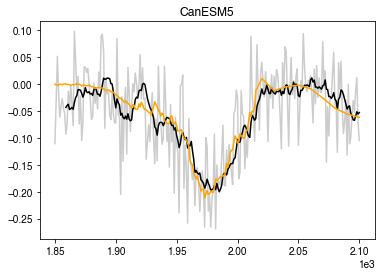

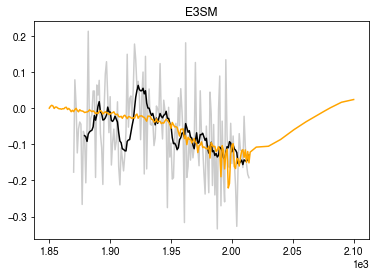

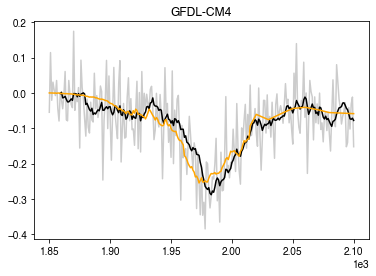

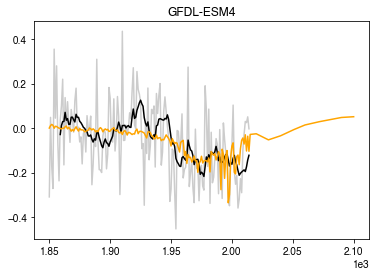

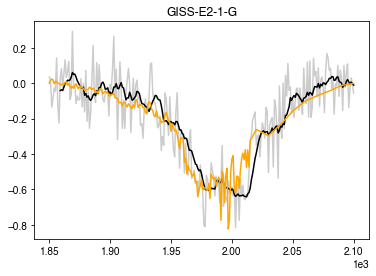

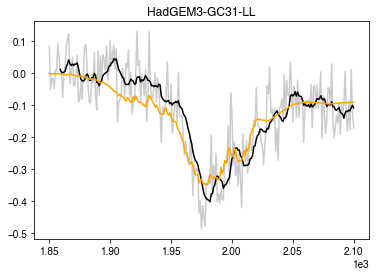

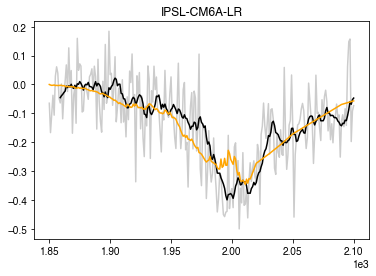

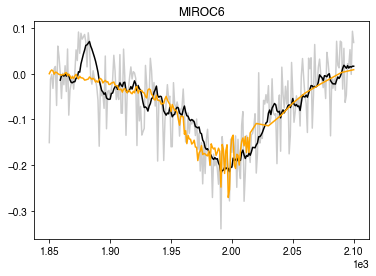

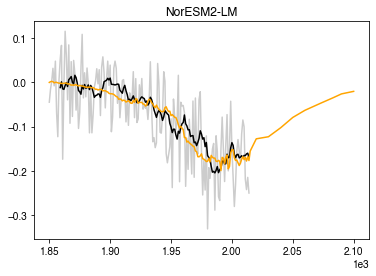

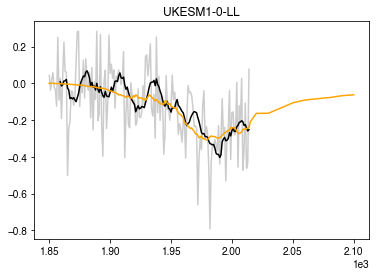

In [38]:
ERFari_coefs = pd.DataFrame(index = CMIP6_aer_forc.columns.levels[0],columns =['bc','oc','so2'])
for model in ERFari_coefs.index:
    ERFari_coefs.loc[model] = get_ari_coefs(model).flatten()

In [39]:
ERFari_coefs.mean()

bc     0.032223
oc    -0.009421
so2   -0.002444
dtype: float64

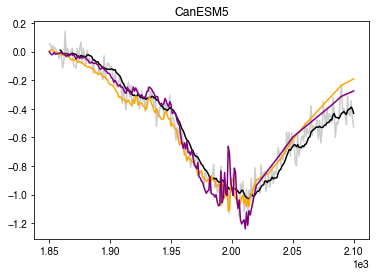

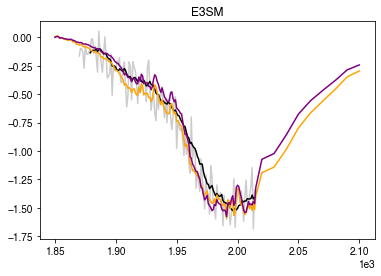

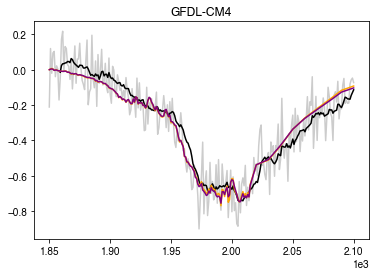

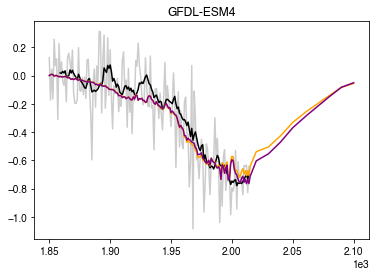

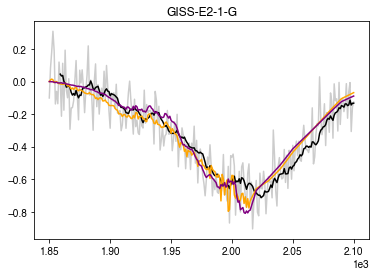

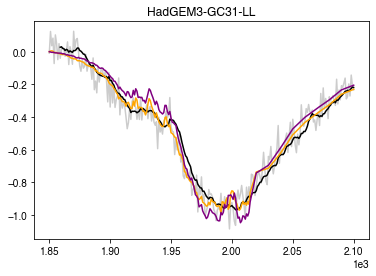

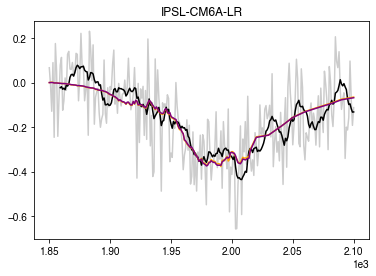

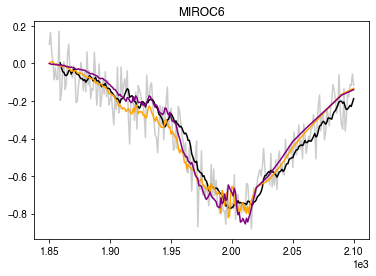

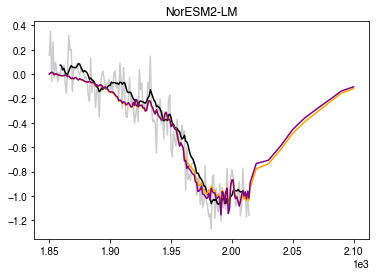

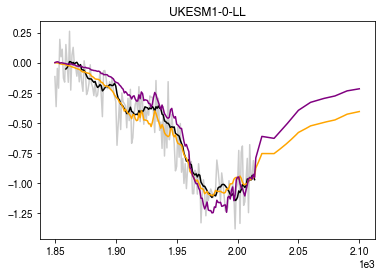

In [40]:
### Now for ERFaci:

def fit_aci(x,model):
    
    model_forc = CMIP6_aer_forc.loc[:,model]
    model_erfaci = (model_forc['aprp_ERFaciSW']+model_forc['aprp_ERFaciLW']).dropna()
    model_erfaci.index = model_erfaci.index.astype(int)
    emms = ssp_emms.loc[:,('esm-ssp245-allGHG',['so2','bc','oc'])]
    emms = emms.loc[model_erfaci.index] - emms.loc[1850]
    
    fit = x[0] * np.log(1 + emms[('esm-ssp245-allGHG','so2')].values / np.exp(x[1]) ) + x[2]*(emms[('esm-ssp245-allGHG','bc')].values+emms[('esm-ssp245-allGHG','oc')].values) #+ np.log(1 + emms[('esm-ssp245-allGHG','bc')].values / np.exp(x[2]) ) + np.log(1 + emms[('esm-ssp245-allGHG','oc')].values / np.exp(x[2]) ) )
    
    return np.sum(abs(fit-model_erfaci))

def fit_aci_lin(model):
    
    model_forc = CMIP6_aer_forc.loc[:,model]
    model_erfaci = (model_forc['aprp_ERFaciSW']+model_forc['aprp_ERFaciLW']).dropna()
    model_erfaci.index = model_erfaci.index.astype(int)
    emms = ssp_emms.loc[:,('esm-ssp245-allGHG',['so2','bc','oc'])]
    emms = emms.loc[model_erfaci.index] - emms.loc[1850]
    
    coefs = OLSE_NORM(emms.loc[model_erfaci.index].values,model_erfaci.values[:,None],add_intercept=False)['coefs']
    
    return coefs

def model_aci(model,params):
    model_forc = CMIP6_aer_forc.loc[:,model]
    model_erfaci = (model_forc['aprp_ERFaciSW']+model_forc['aprp_ERFaciLW']).dropna()
    model_erfaci.index = model_erfaci.index.astype(int)
    emms = ssp_emms.loc[:,('esm-ssp245-allGHG',['so2','bc','oc'])]
    emms -= emms.loc[1850]
    
    fig,ax = plt.subplots()
    model_erfaci.plot(ax=ax,alpha=0.2,c='k')
    model_erfaci.rolling(10).mean().plot(ax=ax,c='k')
    ( params[0]*np.log(1+(emms.loc[1850:2100,('esm-ssp245-allGHG','so2')])/params[1]) + params[2]*(emms.loc[1850:2100,('esm-ssp245-allGHG','bc')]+emms.loc[1850:2100,('esm-ssp245-allGHG','oc')]) ).plot(ax=ax,c='orange')#+np.log(1+(emms.loc[1850:2100,('esm-ssp245-allGHG','bc')])/params[2])+np.log(1+(emms.loc[1850:2100,('esm-ssp245-allGHG','oc')])/params[2]))).plot(ax=ax,c='orange')
    plt.title(model)
    return ax

ERFaci_coefs = pd.DataFrame(index = CMIP6_aer_forc.columns.levels[0],columns =['beta','s','alpha'])
ERFaci_lin_coefs = pd.DataFrame(index = CMIP6_aer_forc.columns.levels[0],columns =['bc','oc','so2'])
    
for model in CMIP6_aer_forc.columns.levels[0]:
    fit_so2 = sp.optimize.minimize(fit_aci,x0=[-0.4,np.log(60),0],args=model,method='nelder-mead').x
    fit_so2[1] = np.exp(fit_so2[1])
#     fit_so2[2] = np.exp(fit_so2[2])
    
    lin_coefs = fit_aci_lin(model)
    ERFaci_lin_coefs.loc[model] = lin_coefs.flatten()
    
    ERFaci_coefs.loc[model] = fit_so2
    ax=model_aci(model,fit_so2)
    emms = ssp_emms.loc[:,('esm-ssp245-allGHG',['so2','bc','oc'])]
    emms = emms.loc[1850:2100] - emms.loc[1850]
    (emms*lin_coefs.T).sum(axis=1).plot(ax=ax,c='purple')
    plt.show()
    

In [41]:
### Validation - 2019 distributions and timeseries

In [42]:
RCMIP_so2_emms = ssp_emms.loc[:2100,('esm-ssp245-allGHG','so2')]
RCMIP_bc_emms = ssp_emms.loc[:2100,('esm-ssp245-allGHG','bc')]
RCMIP_oc_emms = ssp_emms.loc[:2100,('esm-ssp245-allGHG','oc')]

## baseline to 1850

RCMIP_so2_emms -= RCMIP_so2_emms.loc[1850]
RCMIP_bc_emms -= RCMIP_bc_emms.loc[1850]
RCMIP_oc_emms -= RCMIP_oc_emms.loc[1850]

#### ERFari (linear) validation

In [43]:
ari_coef_samples = sp.stats.multivariate_normal(ERFari_coefs.apply(pd.to_numeric).mean(),ERFari_coefs.apply(pd.to_numeric).cov()).rvs(10000)
ari_timeseries =  ari_coef_samples[...,None,0] * RCMIP_bc_emms.values[None] + ari_coef_samples[...,None,1] * RCMIP_oc_emms.values[None] + ari_coef_samples[...,None,2] * RCMIP_so2_emms.values[None]

<AxesSubplot:xlabel='year'>

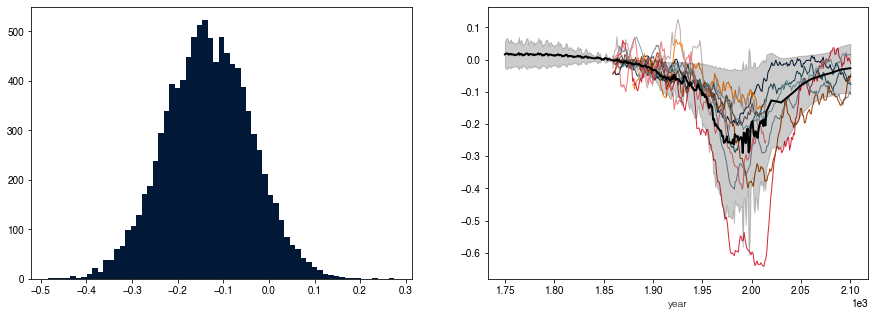

In [44]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(ari_timeseries[:,2019-1750])
ax[1].fill_between(RCMIP_so2_emms.index,*np.quantile(ari_timeseries,[0.05,0.95],axis=0),color='k',alpha=0.2)
ax[1].plot(RCMIP_so2_emms.index,np.quantile(ari_timeseries,0.5,axis=0),color='k',lw=2)
(CMIP6_aer_forc.xs('aprp_ERFariSW',axis=1,level=1)+CMIP6_aer_forc.xs('aprp_ERFariLW',axis=1,level=1)).rolling(10).mean().plot(ax=ax[1],legend=None,zorder=0,lw=1)

#### ERFaci (linear) validation

In [45]:
aci_coef_samples = sp.stats.multivariate_normal(ERFaci_lin_coefs.apply(pd.to_numeric).mean(),ERFaci_lin_coefs.apply(pd.to_numeric).cov()).rvs(10000)
aci_timeseries =  aci_coef_samples[...,None,0] * RCMIP_bc_emms.values[None] + aci_coef_samples[...,None,1] * RCMIP_oc_emms.values[None] + aci_coef_samples[...,None,2] * RCMIP_so2_emms.values[None]

<AxesSubplot:xlabel='year'>

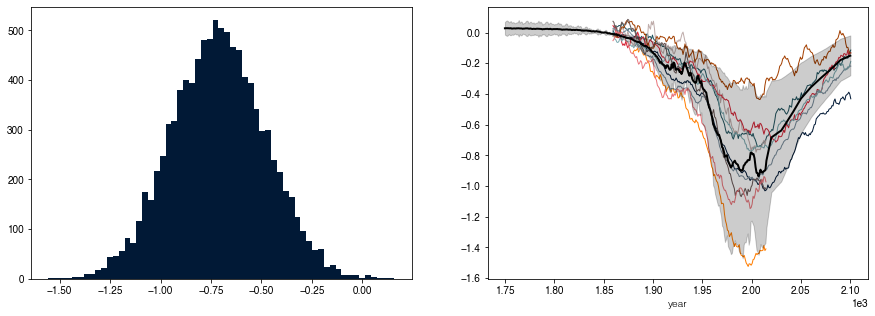

In [46]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(aci_timeseries[:,2019-1750])
ax[1].fill_between(RCMIP_so2_emms.index,*np.quantile(aci_timeseries,[0.05,0.95],axis=0),color='k',alpha=0.2)
ax[1].plot(RCMIP_so2_emms.index,np.quantile(aci_timeseries,0.5,axis=0),color='k',lw=2)
(CMIP6_aer_forc.xs('aprp_ERFaciSW',axis=1,level=1)+CMIP6_aer_forc.xs('aprp_ERFaciLW',axis=1,level=1)).rolling(10).mean().plot(ax=ax[1],legend=None,zorder=0,lw=1)

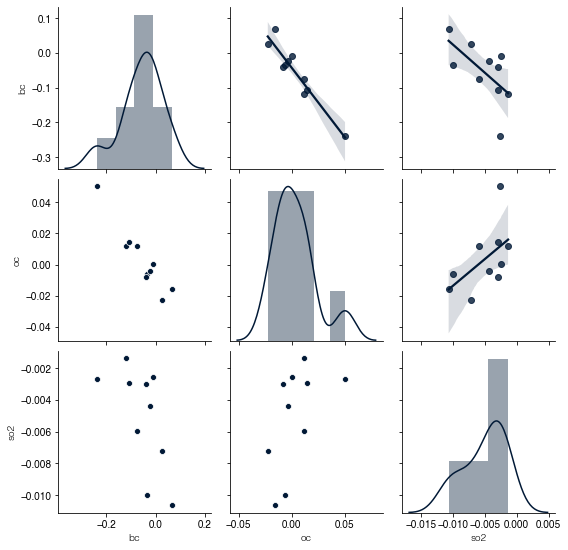

In [47]:
g = sn.PairGrid(ERFaci_lin_coefs.apply(pd.to_numeric),diag_sharey=False)

g.map_diag(sn.distplot)
g.map_lower(sn.scatterplot)
g.map_upper(sn.regplot)

#### ERFaci (log + lin) validation

In [48]:
ERFaci_coefs = ERFaci_coefs.apply(pd.to_numeric)
ERFaci_coefs['log_beta'] = np.log(-1*ERFaci_coefs['beta'])
ERFaci_coefs['log_s'] = np.log(ERFaci_coefs['s'])
ERFaci_coefs['beta_s'] = ERFaci_coefs['beta'] / ERFaci_coefs['s']
ERFaci_coefs['log_beta_s'] = np.log(-1*ERFaci_coefs['beta_s'])

In [49]:
aci_log_beta_samples = sp.stats.norm(ERFaci_coefs['log_beta'].mean(),ERFaci_coefs['log_beta'].std()).rvs(10000)
aci_beta_samples = -1 * np.exp(aci_log_beta_samples)
aci_log_beta_s_samples = sp.stats.norm(ERFaci_coefs['log_beta_s'].mean(),ERFaci_coefs['log_beta_s'].std()).rvs(10000)
aci_s_samples = np.exp(aci_log_beta_samples) / np.exp(aci_log_beta_s_samples)
aci_alpha_samples = sp.stats.norm(ERFaci_coefs['alpha'].mean(),ERFaci_coefs['alpha'].std()).rvs(10000)

aci_timeseries =  aci_beta_samples[...,None] * np.log(1+RCMIP_so2_emms.values[None]/aci_s_samples[...,None]) + aci_alpha_samples[...,None] * (RCMIP_bc_emms.values+RCMIP_oc_emms.values)[None]

<AxesSubplot:xlabel='year'>

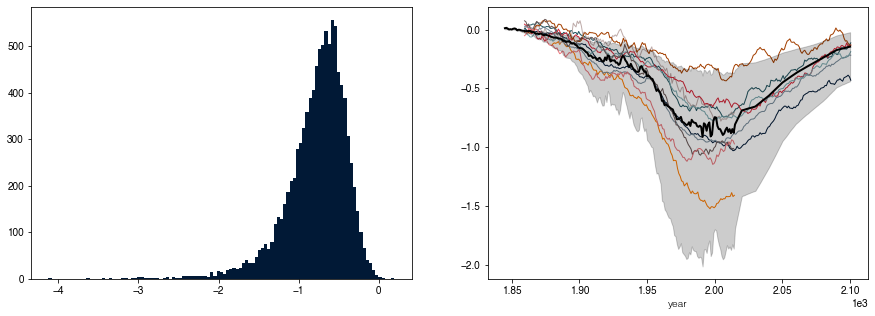

In [50]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(aci_timeseries[:,2019-1750])
ax[1].fill_between(RCMIP_so2_emms.index,*np.quantile(aci_timeseries,[0.05,0.95],axis=0),color='k',alpha=0.2)
ax[1].plot(RCMIP_so2_emms.index,np.quantile(aci_timeseries,0.5,axis=0),color='k',lw=2)
(CMIP6_aer_forc.xs('aprp_ERFaciSW',axis=1,level=1)+CMIP6_aer_forc.xs('aprp_ERFaciLW',axis=1,level=1)).rolling(10).mean().plot(ax=ax[1],legend=None,zorder=0,lw=1)

In [51]:
ERFaci_coefs.loc[:,['log_beta','log_beta_s','alpha']].mean()
print('SO2 f1:',np.exp(ERFaci_coefs.loc[:,'log_beta'].mean()))
print('SO2 PI_conc:',np.exp(ERFaci_coefs.loc[:,'log_beta'].mean())/np.exp(ERFaci_coefs.loc[:,'log_beta_s'].mean()))
print('OC,BC f3:',ERFaci_coefs.loc[:,'alpha'].mean())

SO2 f1: 1.4100166818467434
SO2 PI_conc: 177.11377050971288
OC,BC f3: -0.01052545531769231


In [52]:
ERFaci_coefs.to_csv('Parameter_Sets/CMIP6_ERFaci.csv')
ERFari_coefs.to_csv('Parameter_Sets/CMIP6_ERFari.csv')

## Ozone radiative parameters

Here we add in the radiative efficiencies of species that are reactive with O$_3$ in some form: CH$_4$, CO, NOx, (H)CFCs, NMVOC

In [53]:
## Source= Holmes (2013)
CH4_2011_pert = CH4_concs.loc[2011]-720
print('trop ozone CH4 forc = ',(0.15-0.017)/1000,'W m$^{-2}$ ppb${-1}$')
# print('strat ozone CH4 forc = ',(0.082-0.02)/1000,'W m$^{-2}$ ppb${-1}$')
print('ozone H2O strat forc = ',(0.055)/1000,'W m$^{-2}$ ppb${-1}$')

trop ozone CH4 forc =  0.000133 W m$^{-2}$ ppb${-1}$
ozone H2O strat forc =  5.5e-05 W m$^{-2}$ ppb${-1}$


In [54]:
# source = AR5
CO_2011_pert = CEDS_aerosols.loc[2011,'co']
print('ozone CO forc = ',(0.075)/CO_2011_pert,'W m$^{-2}$ Mt${-1}$')

ozone CO forc =  0.00012203714234203333 W m$^{-2}$ Mt${-1}$


In [55]:
# source = AR5
NOx_2011_pert = CEDS_aerosols.loc[2011,'nox']
print('ozone NOx forc = ',(0.143)/(NOx_2011_pert),'W m$^{-2}$ MtN${-1}$')

ozone NOx forc =  0.0009781281948883177 W m$^{-2}$ MtN${-1}$


In [56]:
# source = AR5
VOC_2011_pert = CEDS_aerosols.loc[2011,'nmvoc']
print('ozone VOC forc = ',(0.042)/VOC_2011_pert,'W m$^{-2}$ Mt${-1}$')

ozone VOC forc =  0.00025826768273333695 W m$^{-2}$ Mt${-1}$


#### The tricky part: ODS (CFCs/HCFCs)

In [57]:
# divide ODP by tau, then divide by concentraion above PI and multiply by factor such that the total is -0.15
## multiply by 1000 to convert from ppt to ppb
ozone_rf_target_2011 = -0.05 #- CH4_2011_pert * 6.2e-05
WMGHG_data['Ozone_RE']=1000*(WMGHG_data.ODP / WMGHG_data.tau) *ozone_rf_target_2011/((WMGHG_concs.loc[2011]-WMGHG_concs.loc[1650:1750].mean())*(WMGHG_data.ODP / WMGHG_data.tau)).dropna().sum()
WMGHG_data = WMGHG_data.apply(pd.to_numeric)

## Black Carbon on snow

In [58]:
RCMIP_bc = RCMIP_emms.loc[('World','ssp245','Emissions|BC')].iloc[4:].apply(pd.to_numeric).interpolate()
RCMIP_bc -= RCMIP_bc.loc['1750']

print('bc|bc_on_snow f2:',0.08 / RCMIP_bc.loc['2018'],'W m$^{-2}$ MtN${-1}$')

bc|bc_on_snow f2: 0.011289691839377745 W m$^{-2}$ MtN${-1}$


## Contrails

In [59]:
RCMIP_nox_avi = RCMIP_emms.loc[('World','ssp245','Emissions|NOx|MAGICC Fossil and Industrial|Aircraft')].iloc[4:].apply(pd.to_numeric).interpolate()
RCMIP_nox_avi -= RCMIP_nox_avi.loc['1750']

print('nox_avi|contrails f2:',0.04 / RCMIP_nox_avi.loc['2018'],'W m$^{-2}$ MtN${-1}$')

nox_avi|contrails f2: 0.011457724967471751 W m$^{-2}$ MtN${-1}$


## Adding it all together to create a parameter set

In [60]:
default_params = pd.DataFrame(columns=WMGHG_concs.columns,index=['a1', 'a2', 'a3', 'a4', 'tau1', 'tau2', 'tau3', 'tau4', 'r0', 'rC','rT', 'rA', 'PI_conc', 'emis2conc', 'f1', 'f2', 'f3'])

In [61]:
#CO2
default_params.loc[:,'carbon_dioxide'] = [0.2173,0.2240,0.2824,0.2763,1e9,394.4,36.54,4.304,31.52,0.01223,2.681,0,278,28.966/(5.148 * 12),4.57,0,0.086]
#CH4
default_params.loc[:,'methane'] = [1,0,0,0,8.1,0,0,0,8.1,0,-0.287,0.000343,720,28.966/(5.148 * 16),0,0,0.039]
#N2O (measured in N2O-N2)
default_params.loc[:,'nitrous_oxide'] = [1,0,0,0,116,0,0,0,67.01,0,0,0,273,28.966/(5.148 * 28),0,0,0.12]
#Other WMGHGs
default_params.loc[:,WMGHG_data.dropna().index] = 0
default_params.loc['a1',WMGHG_data.dropna().index] = 1
## the r0 calculation for very large tau values is unstable due to float limits, so we scale the tau values by 1/100
default_params.loc['tau1',WMGHG_data.dropna().index] = WMGHG_data.dropna().tau/100
g1 = (WMGHG_data.dropna().tau/100) * ( 1. - ( 1. + 100/(WMGHG_data.dropna().tau/100) ) * np.exp(-100/(WMGHG_data.dropna().tau/100)) )
g0 = ( np.sinh( (WMGHG_data.dropna().tau/100) * ( 1. - np.exp(-100/(WMGHG_data.dropna().tau/100)) )  / g1 ) )**(-1.)
default_params.loc['r0',WMGHG_data.dropna().index] = g1*np.arcsinh(100/g0)
## scale concs by 1000 for the ppt -> ppb conversion (need to add the 1e-30 to avoid div_by_zero errors)
default_params.loc['PI_conc',WMGHG_data.dropna().index] =  1e-15 + WMGHG_concs.loc[1750,WMGHG_data.dropna().index] / 1000
default_params.loc['emis2conc',WMGHG_data.dropna().index] = 28.966/(5.148 * WMGHG_data.dropna().MW)
default_params.loc['f2',WMGHG_data.dropna().index] = WMGHG_data.dropna().RE
#Aerosols (FaIR + Smith informed model)
## note that the emis2conc is 1 since emissions are converted directly to concs
## the emissions units are: MtSO2, MtNO2, MtCO, MtNMVOC

default_params.loc[:,'so2'] = [1,0,0,0,1,0,0,0,1,0,0,0,177,1,0,-0.002444,0]
default_params.loc[:,'nox'] = [1,0,0,0,1,0,0,0,1,0,0,0,1e-15,1,0,0,0]
default_params.loc[:,'nox_avi'] = [1,0,0,0,1,0,0,0,1,0,0,0,1e-15,1,0,0,0]
default_params.loc[:,'co'] = [1,0,0,0,1,0,0,0,1,0,0,0,1e-15,1,0,0,0]
default_params.loc[:,'nmvoc'] = [1,0,0,0,1,0,0,0,1,0,0,0,1e-15,1,0,0,0]
default_params.loc[:,'bc'] = [1,0,0,0,1,0,0,0,1,0,0,0,1e-15,1,0,0.032223,0]
default_params.loc[:,'nh3'] = [1,0,0,0,1,0,0,0,1,0,0,0,1e-15,1,0,0,0]
default_params.loc[:,'oc'] = [1,0,0,0,1,0,0,0,1,0,0,0,1e-15,1,0,-0.009421,0]

for species in default_params.columns:
    if species=='carbon_dioxide':
        continue
    else:
        default_params.loc['tau2':'tau4',species]=1

#Ozone RFs
# default_params.loc[:,'methane|strat_o3'] = np.nan
# default_params.loc['f1':'f3','methane|strat_o3'] = 0
# default_params.loc['f2','methane|strat_o3'] = 6.2e-05
default_params.loc[:,'methane|trop_o3'] = np.nan
default_params.loc['f1':'f3','methane|trop_o3'] = 0
default_params.loc['f2','methane|trop_o3'] = 0.000133
default_params.loc[:,'methane|strat_h2o'] = np.nan
default_params.loc['f1':'f3','methane|strat_h2o'] = 0
default_params.loc['f2','methane|strat_h2o'] = 5.5e-05

default_params.loc[:,'co|trop_o3'] = np.nan
default_params.loc['f1':'f3','co|trop_o3'] = 0
default_params.loc['f2','co|trop_o3'] = 0.00012
default_params.loc[:,'nox|trop_o3'] = np.nan
default_params.loc['f1':'f3','nox|trop_o3'] = 0
default_params.loc['f2','nox|trop_o3'] = 0.00098
default_params.loc[:,'nmvoc|trop_o3'] = np.nan
default_params.loc['f1':'f3','nmvoc|trop_o3'] = 0
default_params.loc['f2','nmvoc|trop_o3'] = 0.00026

#BC on snow
default_params.loc[:,'bc|bc_on_snow'] = np.nan
default_params.loc['f1':'f3','bc|bc_on_snow'] = 0
default_params.loc['f2','bc|bc_on_snow'] = 0.0113 # increased since FaIRv1.5 for consistency with AR6

#Contrails
default_params.loc[:,'nox_avi|contrails'] = np.nan
default_params.loc['f1':'f3','nox_avi|contrails'] = 0
default_params.loc['f2','nox_avi|contrails'] =  0.0115# reduced since FaIRv1.5 for consistency with AR6

#ari and aci using parameterisation
default_params.loc[:,'so2|aci'] = np.nan
default_params.loc['f1':'f3','so2|aci'] = 0
default_params.loc['f1','so2|aci'] = -1.41
default_params.loc[:,'bc|aci'] = np.nan
default_params.loc['f1':'f3','bc|aci'] = 0
default_params.loc['f2','bc|aci'] = -0.0105
default_params.loc[:,'oc|aci'] = np.nan
default_params.loc['f1':'f3','oc|aci'] = 0
default_params.loc['f2','oc|aci'] = -0.0105

for ODS in WMGHG_data.dropna().index[WMGHG_data.dropna().Ozone_RE!=0]:
    default_params.loc['f1':'f3',ODS+'|strat_o3'] = 0
    default_params.loc['f2',ODS+'|strat_o3'] = WMGHG_data.loc[ODS,'Ozone_RE']
    
default_params = pd.concat([default_params],keys=['default'],axis=1)

In [62]:
## lets try a run!
test_concs_run = WMGHG_concs.loc[1750:].copy()
test_concs_run.loc[:,WMGHG_data.dropna().index] /= 1000
for aerosol in ['so2','nmvoc','co','nox','nh3','oc','bc']:
    test_concs_run.loc[:,aerosol] = CEDS_aerosols.loc[:,aerosol].values - CEDS_aerosols.loc[1750,aerosol]
    test_concs_run.loc[:,aerosol] += default_params.loc['PI_conc',('default',aerosol)] # have to add on the "pre-industrial" concentration
test_concs_run.loc[:,'nox_avi'] = 0
test_concs_run.loc[1855:2014,'nox_avi'] = pd.read_csv('https://raw.githubusercontent.com/openclimatedata/ceds/master/data/nox.csv').set_index('Sector').loc[['1A3aii_Domestic-aviation','1A3ai_International-aviation']].reset_index().groupby(['Year'])['Value'].sum()/1000

test_concs_run = pd.concat([test_concs_run],keys=['historical'],axis=1)

In [63]:
test_run = run_GIR(concentrations_in=test_concs_run+1e-30,gas_parameters=default_params)

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon

100%|██████████| 264/264 [00:00<00:00, 5753.00 timestep/s]


### Output checks

<AxesSubplot:xlabel='Year'>

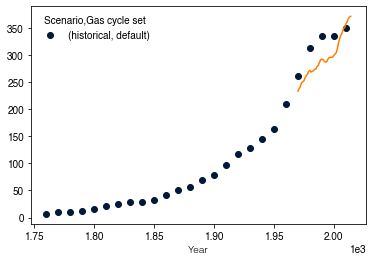

In [64]:
test_run['Emissions'].xs('methane',axis=1,level=-1).rolling(2).mean().rolling(10,center=True).mean().iloc[::10].plot(marker='o',lw=0)
(pd.read_csv('https://raw.githubusercontent.com/openclimatedata/ceds/master/data/ch4.csv').groupby('Year')['Value'].sum()/1000).plot()

<AxesSubplot:xlabel='Year'>

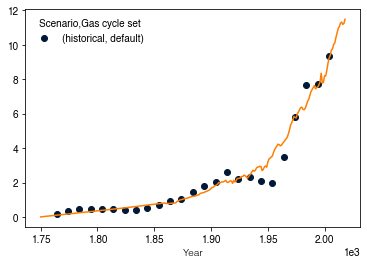

In [65]:
test_run['Emissions'].xs('carbon_dioxide',axis=1,level=-1).rolling(2).mean().rolling(10,center=True).mean().iloc[::-10].plot(marker='o',lw=0)
GCP_historical_emissions.sum(axis=1).plot()

<AxesSubplot:xlabel='year'>

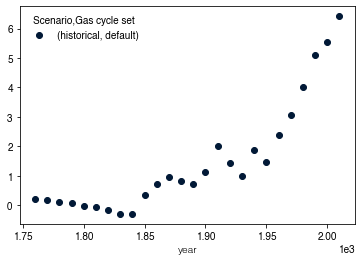

In [66]:
test_run['Emissions'].xs('nitrous_oxide',axis=1,level=-1).rolling(2).mean().rolling(10,center=True).mean().iloc[::10].plot(marker='o',lw=0)

#### Ozone & aerosol rf:

<AxesSubplot:xlabel='year'>

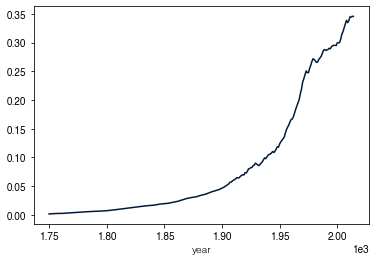

In [67]:
test_run['RF']['historical']['default'][[x for x in default_params.columns.levels[1] if 'o3' in x]].sum(axis=1).plot()

## SAVE the parameter set

In [68]:
default_params.to_csv('./Parameter_Sets/Complete_gas_cycle_params.csv')